In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,cohen_kappa_score,classification_report
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import statsmodels.api as sm
from imblearn.over_sampling import RandomOverSampler


warnings.filterwarnings('ignore')
pd.set_option('display.max_rows',None)

## Data Importing and Exploring

In [2]:
data = pd.read_csv('Expense.csv',na_values=' ?')

In [3]:
data.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Expense
0,39,Self-emp-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,15024,0,50,United-States,>50K
1,20,Private,Some-college,10,Never-married,Other-service,Own-child,White,Male,0,0,40,United-States,<=50K
2,50,Private,Doctorate,16,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,1902,65,United-States,>50K
3,38,State-gov,HS-grad,9,Married-civ-spouse,Prof-specialty,Wife,White,Female,0,0,40,United-States,>50K
4,23,Local-gov,Bachelors,13,Never-married,Prof-specialty,Own-child,White,Female,0,0,60,United-States,<=50K


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             5000 non-null   int64 
 1   workclass       4680 non-null   object
 2   education       5000 non-null   object
 3   education-num   5000 non-null   int64 
 4   marital-status  5000 non-null   object
 5   occupation      4679 non-null   object
 6   relationship    5000 non-null   object
 7   race            5000 non-null   object
 8   sex             5000 non-null   object
 9   capital-gain    5000 non-null   int64 
 10  capital-loss    5000 non-null   int64 
 11  hours-per-week  5000 non-null   int64 
 12  native-country  4902 non-null   object
 13  Expense         5000 non-null   object
dtypes: int64(5), object(9)
memory usage: 547.0+ KB


In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,5000.0,38.6560,13.698292,17.0,28.0,37.0,48.0,90.0
education-num,5000.0,10.0650,2.558141,1.0,9.0,10.0,12.0,16.0
capital-gain,5000.0,1104.0800,7579.674371,0.0,0.0,0.0,0.0,99999.0
capital-loss,5000.0,90.0328,404.168991,0.0,0.0,0.0,0.0,3004.0
hours-per-week,5000.0,40.5662,12.154191,1.0,40.0,40.0,45.0,99.0


In [6]:
data.describe(include='object').T

,count,unique,top,freq
workclass,4680,8,Private,3444
education,5000,16,HS-grad,1602
marital-status,5000,7,Married-civ-spouse,2294
occupation,4679,14,Craft-repair,630
relationship,5000,6,Husband,2026
race,5000,5,White,4271
sex,5000,2,Male,3374
native-country,4902,39,United-States,4459
Expense,5000,2,<=50K,3776


In [7]:
data.isnull().sum()

age                 0
workclass         320
education           0
education-num       0
marital-status      0
occupation        321
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country     98
Expense             0
dtype: int64

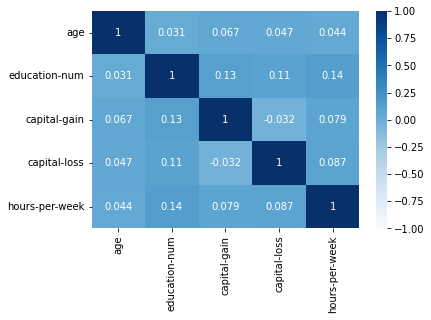

In [8]:
sns.heatmap(data.corr(numeric_only=True),annot=True,vmax=1,vmin=-1,cmap='Blues')
plt.show()

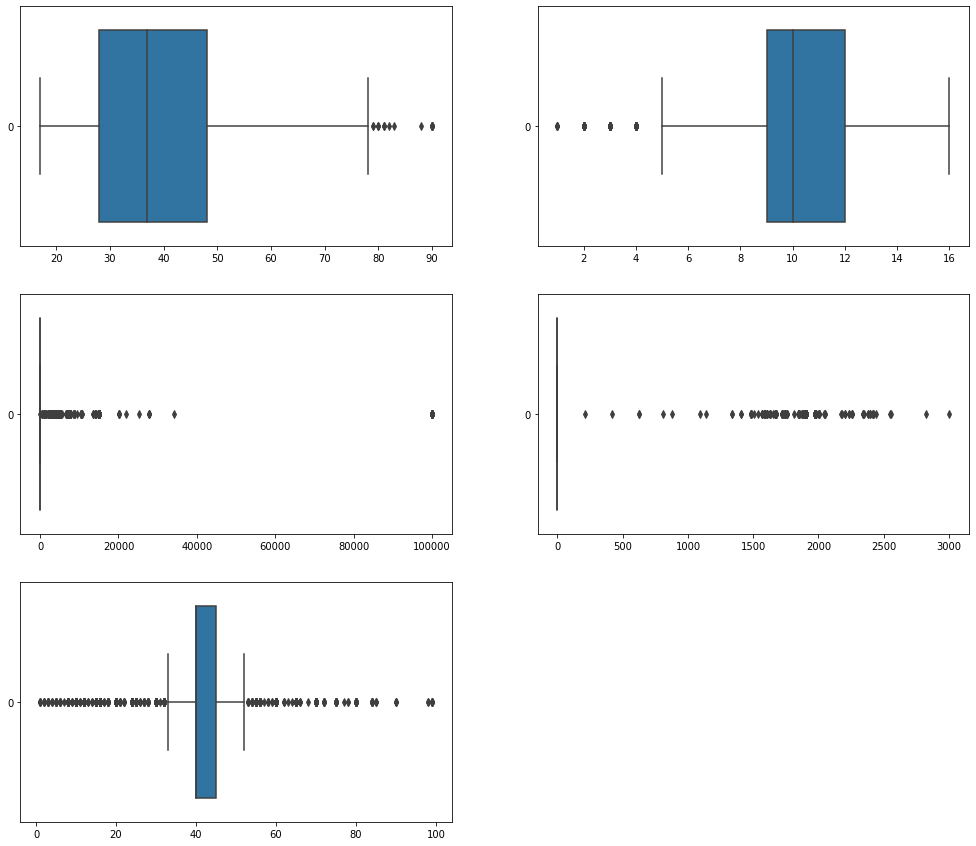

In [9]:
plt.figure(figsize=(17,15))
t=1
for i in data.select_dtypes(include=np.number).columns:
    plt.subplot(3,2,t)
    sns.boxplot(data[i],orient='h')
    t=t+1
plt.show()

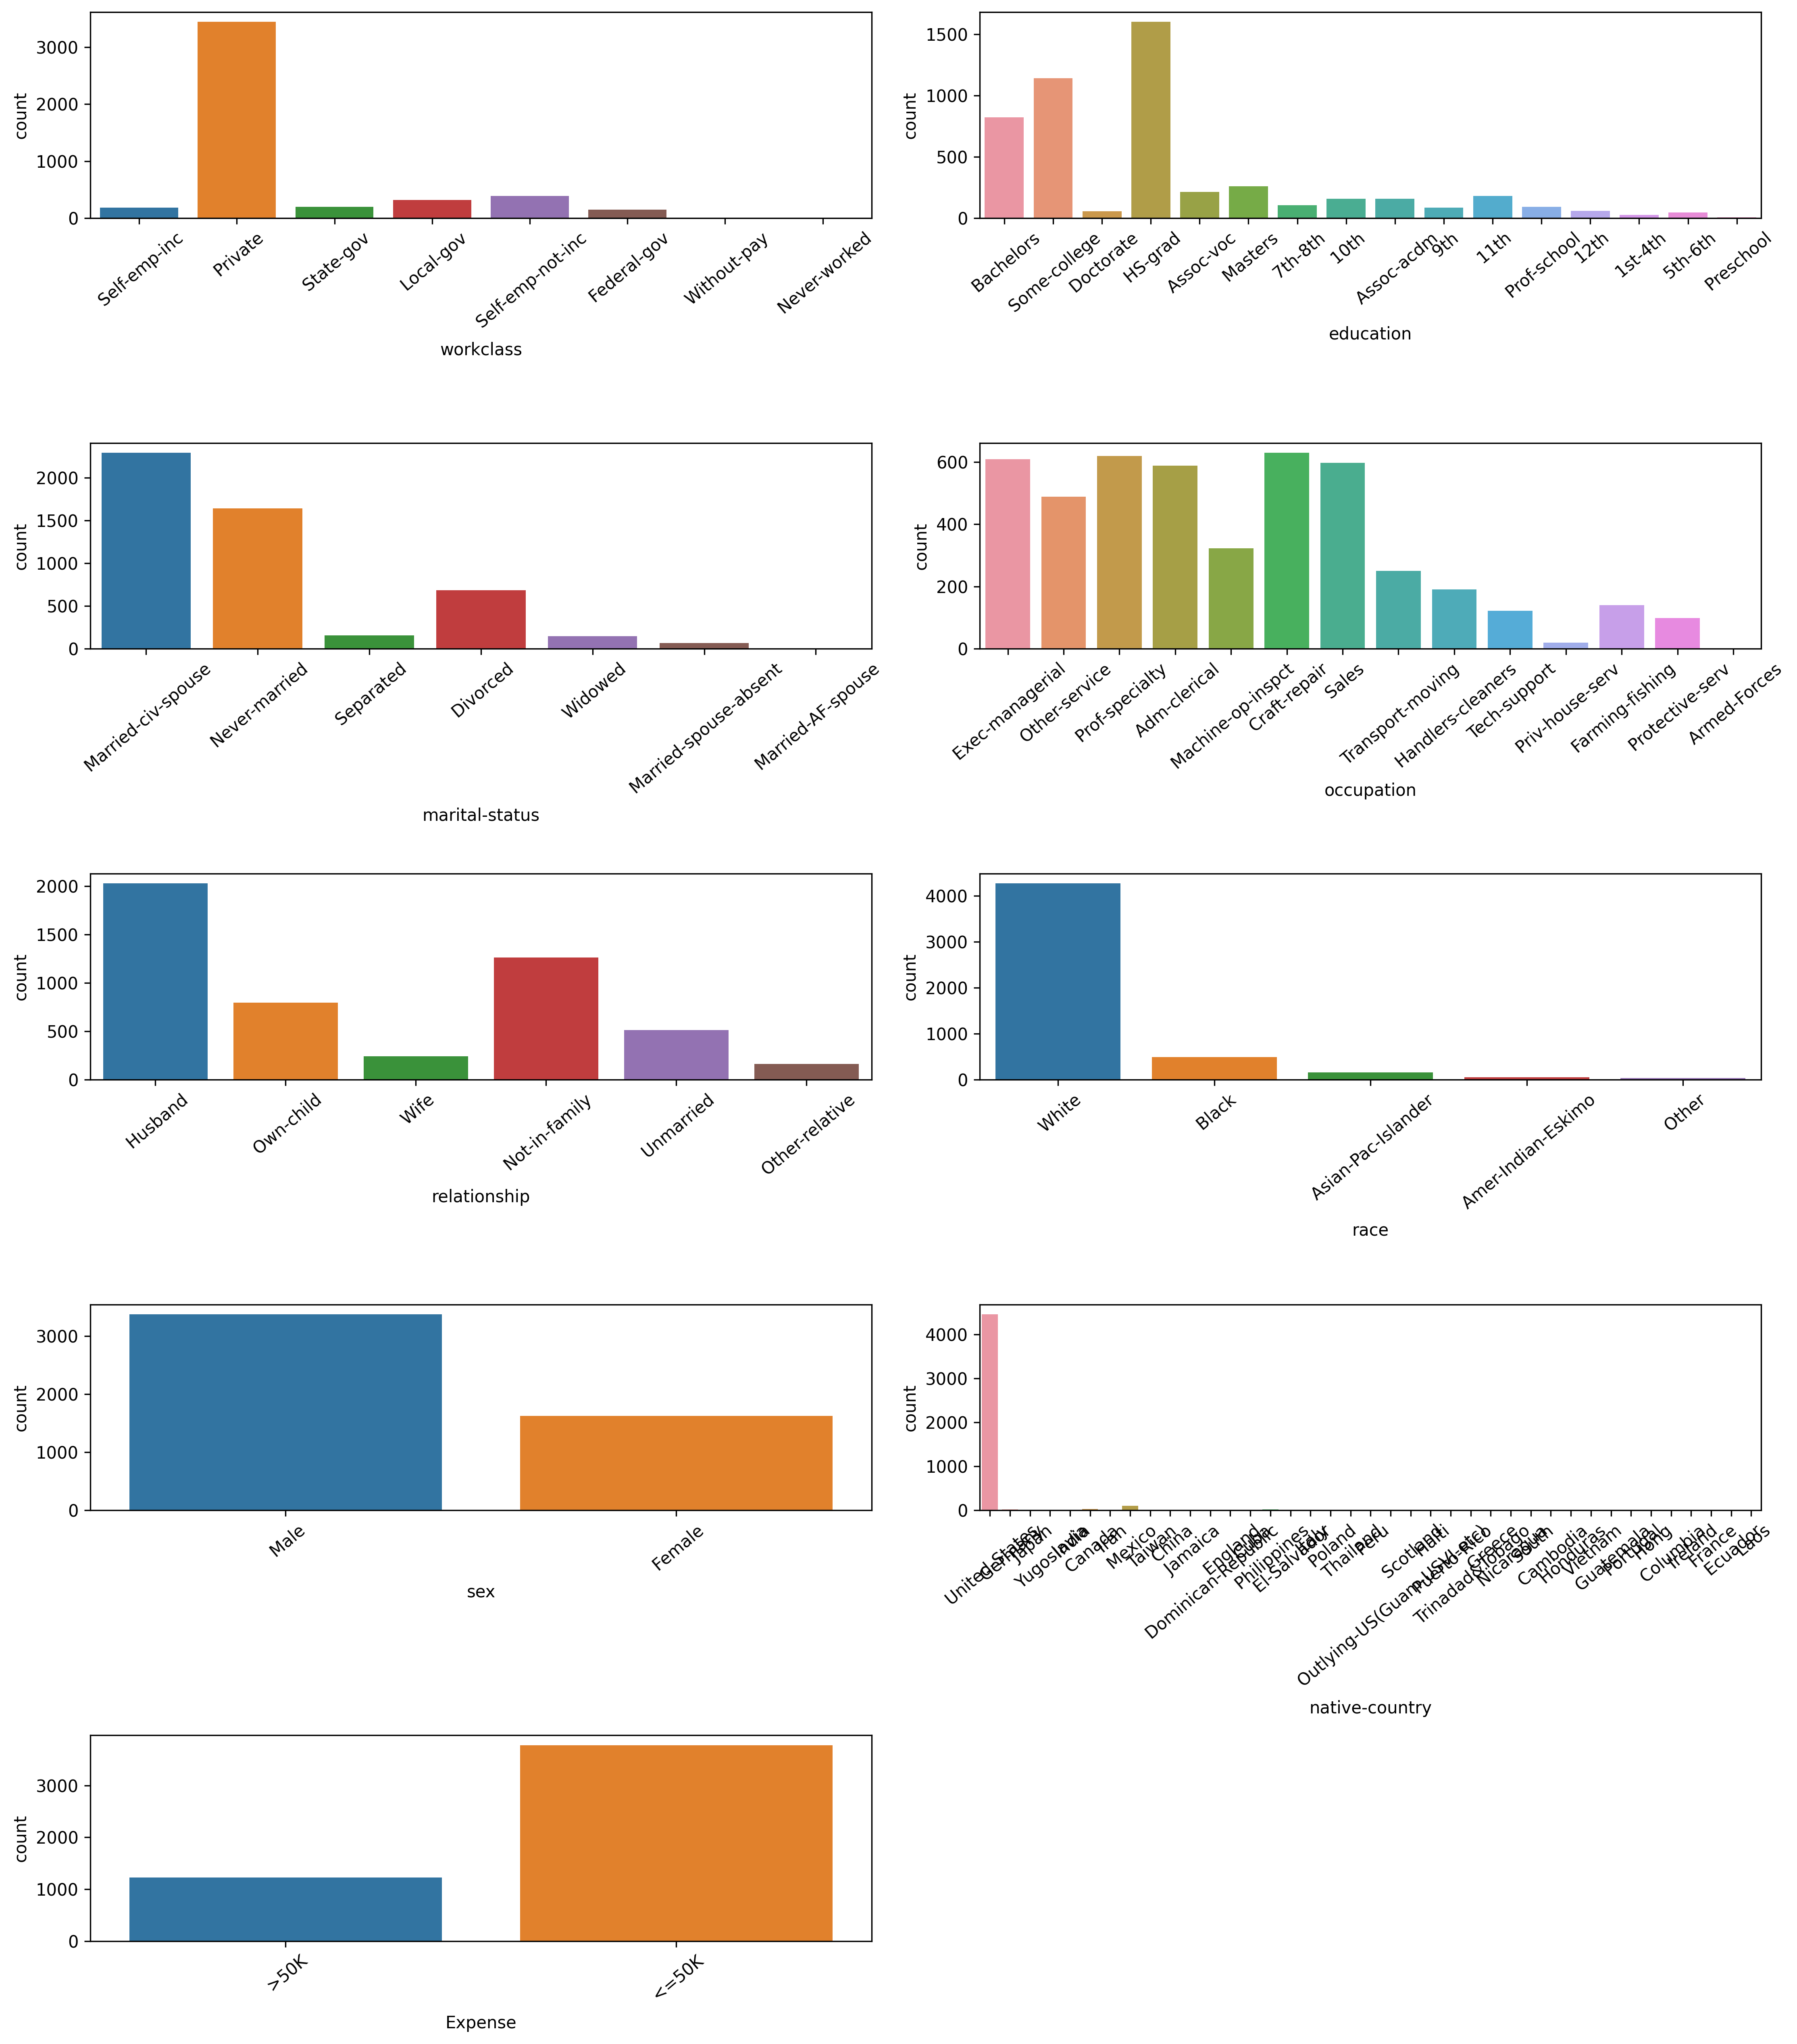

In [10]:
plt.figure(figsize=(15,17),dpi=300)
t=1
for i in data.select_dtypes(include='object').columns:
    plt.subplot(5,2,t)
    sns.countplot(data=data,x=i)
    plt.xticks(rotation=40)
    t=t+1
plt.tight_layout()
plt.show()

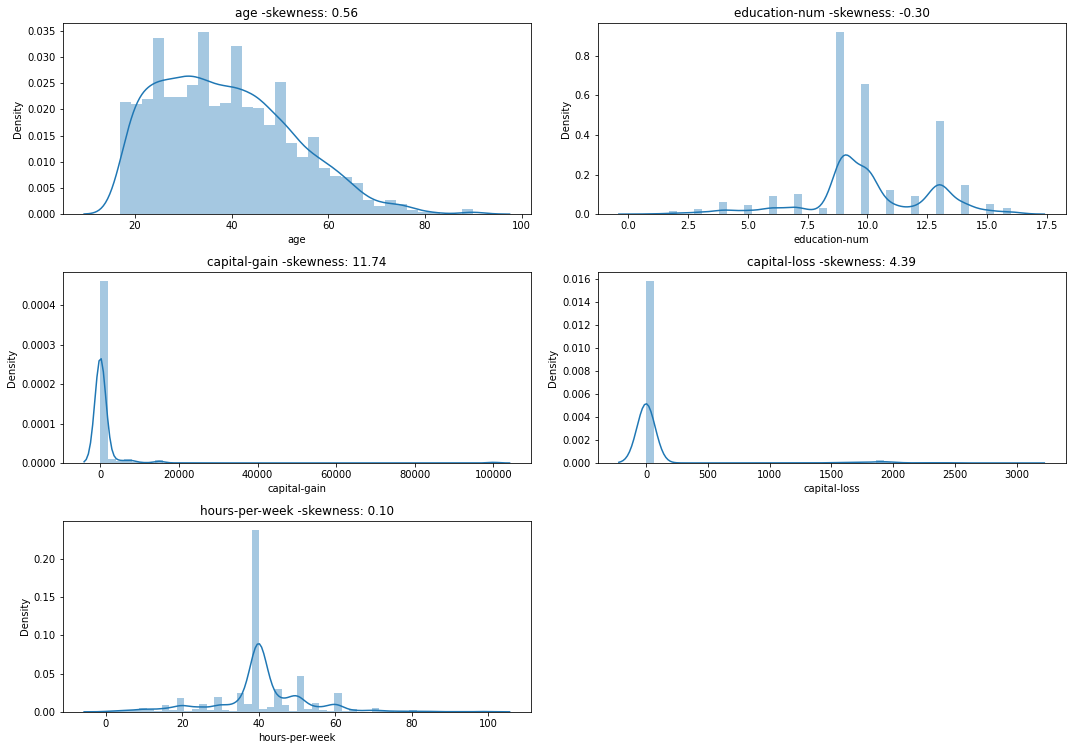

In [11]:
plt.figure(figsize=(15,17))
t=1
for i in data.select_dtypes(include=np.number).columns:
    plt.subplot(5,2,t)
    sns.distplot(data[i])
    plt.title('%s -skewness: %.2f'%(i,data[i].skew()))
    t=t+1
plt.tight_layout()
plt.show()

## Missing value Treatment

In [12]:
edu_df = pd.DataFrame(data.groupby(by=['education-num','education'])['education'].count())

In [13]:
edu_df.sort_values(by=['education-num'])

,,education
education-num,education,
1,Preschool,5
2,1st-4th,25
3,5th-6th,46
4,7th-8th,105
5,9th,84
6,10th,156
7,11th,179
8,12th,57
9,HS-grad,1602


In [14]:
from scipy.stats import chi2_contingency

In [15]:
cont_table = pd.crosstab(data['workclass'],data['education-num'])

In [16]:
chi,p_value,dof,expected = chi2_contingency(cont_table)

In [17]:
if p_value>0.05:
    print('the two columns are independednt: Accept Ho')
else:
    print('the two columns are dependent: Accept Ha')

the two columns are dependent: Accept Ha


In [18]:
data[data['workclass'].isnull()]

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Expense
20,19,NaN,HS-grad,9,Never-married,NaN,Own-child,White,Male,0,0,30,United-States,<=50K
35,76,NaN,7th-8th,4,Widowed,NaN,Not-in-family,White,Male,0,0,2,United-States,<=50K
36,19,NaN,HS-grad,9,Never-married,NaN,Unmarried,White,Male,0,2001,40,United-States,<=50K
40,34,NaN,11th,7,Married-civ-spouse,NaN,Wife,White,Female,0,0,8,United-States,<=50K
47,64,NaN,Assoc-acdm,12,Never-married,NaN,Not-in-family,White,Female,0,0,20,United-States,<=50K
98,19,NaN,HS-grad,9,Never-married,NaN,Own-child,White,Female,0,0,40,United-States,<=50K
101,68,NaN,7th-8th,4,Married-civ-spouse,NaN,Husband,White,Male,0,0,8,United-States,<=50K
132,34,NaN,HS-grad,9,Divorced,NaN,Not-in-family,White,Female,0,0,40,United-States,<=50K
135,42,NaN,Some-college,10,Divorced,NaN,Unmarried,White,Male,0,0,40,United-States,<=50K
153,24,NaN,Some-college,10,Never-married,NaN,Not-in-family,White,Male,0,0,40,NaN,<=50K


In [19]:
data.groupby(by=['education','workclass'])['workclass'].count()

education      workclass        
 10th           Local-gov              4
                Never-worked           1
                Private              114
                Self-emp-inc           4
                Self-emp-not-inc      13
                State-gov              2
 11th           Federal-gov            2
                Local-gov              8
                Private              140
                Self-emp-inc           2
                Self-emp-not-inc       5
                State-gov              2
 12th           Federal-gov            1
                Local-gov              3
                Private               41
                Self-emp-not-inc       7
 1st-4th        Private               22
                Self-emp-not-inc       3
 5th-6th        Local-gov              1
                Private               39
                Self-emp-not-inc       2
 7th-8th        Federal-gov            1
                Local-gov              6
                Private 

In [20]:
data['workclass'].fillna('Private',inplace=True)

In [21]:
data.isnull().sum()

age                 0
workclass           0
education           0
education-num       0
marital-status      0
occupation        321
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country     98
Expense             0
dtype: int64

In [22]:
data.groupby(by=['education','occupation'])['occupation'].count()

education      occupation        
 10th           Adm-clerical           7
                Craft-repair          31
                Exec-managerial        5
                Farming-fishing        7
                Handlers-cleaners      9
                Machine-op-inspct     19
                Other-service         19
                Priv-house-serv        2
                Prof-specialty         1
                Protective-serv        2
                Sales                 19
                Tech-support           1
                Transport-moving      15
 11th           Adm-clerical          11
                Craft-repair          28
                Exec-managerial        3
                Farming-fishing        5
                Handlers-cleaners     13
                Machine-op-inspct     18
                Other-service         38
                Priv-house-serv        1
                Prof-specialty         3
                Sales                 22
                Tech-su

In [23]:
for i in range(1,17):  
    data['occupation']= np.where(data['occupation'].isnull() & (data['education-num']==i),
                            data[data['education-num']==i]['occupation'].mode()[0],
                            data['occupation'])

In [24]:
data.isnull().sum()

age                0
workclass          0
education          0
education-num      0
marital-status     0
occupation         0
relationship       0
race               0
sex                0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country    98
Expense            0
dtype: int64

In [25]:
data['native-country'].fillna(data['native-country'].mode()[0],inplace=True)

In [26]:
data.isnull().sum()

age               0
workclass         0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
Expense           0
dtype: int64

## Outlier Treatment

In [27]:
# Outlier treatment- capping with UL and LL

for i in ['age','education-num','hours-per-week']:
    Q1,Q3 = np.quantile(data[i],[0.25,0.75])
    IQR = Q3-Q1
    UL = Q3+(1.5*IQR)
    LL = Q1-(1.5*IQR)

    data.loc[data[i]>UL,i]=UL
    data.loc[data[i]<LL,i]=LL

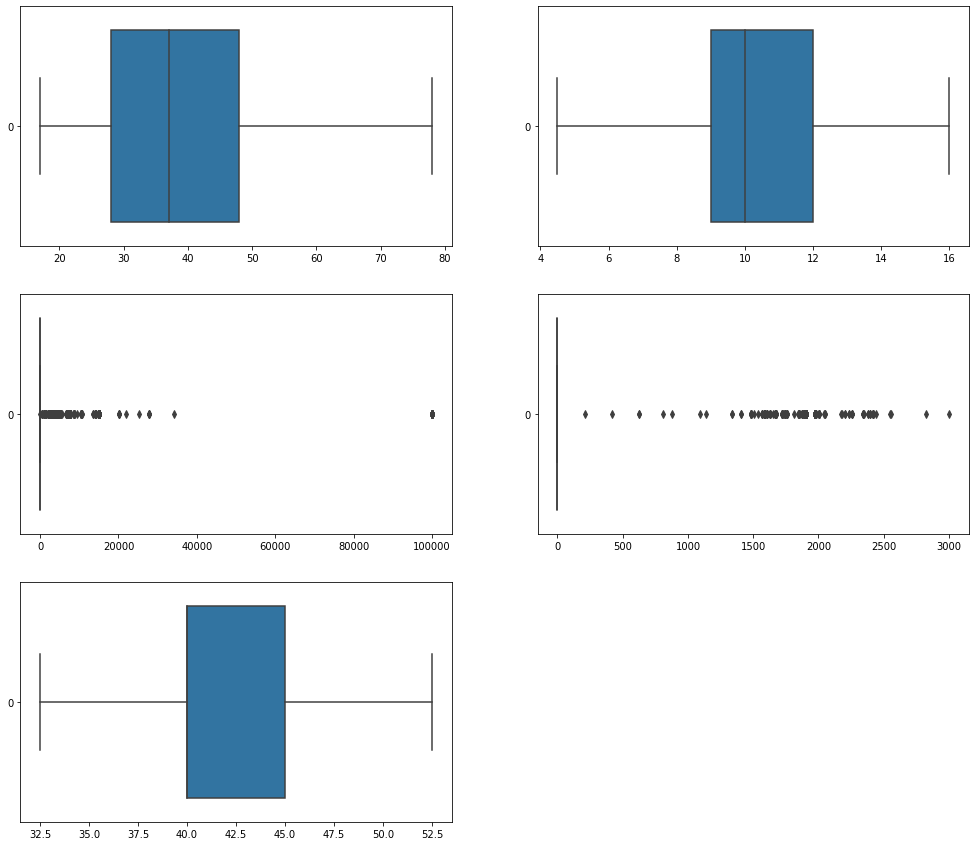

In [28]:
plt.figure(figsize=(17,15))
t=1
for i in data.select_dtypes(include=np.number).columns:
    plt.subplot(3,2,t)
    sns.boxplot(data[i],orient='h')
    t=t+1
plt.show()

In [29]:
data['capital-gain'] = np.where(data['capital-gain']>0,1,data['capital-gain'])
data['capital-loss'] = np.where(data['capital-loss']>0,1,data['capital-loss'])

In [30]:
data.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Expense
0,39,Self-emp-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,1,0,50.0,United-States,>50K
1,20,Private,Some-college,10.0,Never-married,Other-service,Own-child,White,Male,0,0,40.0,United-States,<=50K
2,50,Private,Doctorate,16.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,1,52.5,United-States,>50K
3,38,State-gov,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Wife,White,Female,0,0,40.0,United-States,>50K
4,23,Local-gov,Bachelors,13.0,Never-married,Prof-specialty,Own-child,White,Female,0,0,52.5,United-States,<=50K


## Categorical Column treatment

In [31]:
data['workclass'].value_counts().index

Index([' Private', ' Self-emp-not-inc', 'Private', ' Local-gov', ' State-gov',
       ' Self-emp-inc', ' Federal-gov', ' Without-pay', ' Never-worked'],
      dtype='object', name='workclass')

In [32]:
def workclass(data):
    if data in [' Private','Private']:
        return 'Private'
    elif data in [' Self-emp-not-inc',' Self-emp-inc']:
        return 'Self-emp'
    elif data in [' Local-gov',' State-gov',' Federal-gov']:
        return 'Gov'
    else:
        return 'Others'

In [33]:
data['workclass']= data['workclass'].apply(workclass)

In [34]:
data['workclass'].value_counts()

workclass
Private     3764
Gov          665
Self-emp     569
Others         2
Name: count, dtype: int64

In [35]:
data.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Expense
0,39,Self-emp,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,1,0,50.0,United-States,>50K
1,20,Private,Some-college,10.0,Never-married,Other-service,Own-child,White,Male,0,0,40.0,United-States,<=50K
2,50,Private,Doctorate,16.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,1,52.5,United-States,>50K
3,38,Gov,HS-grad,9.0,Married-civ-spouse,Prof-specialty,Wife,White,Female,0,0,40.0,United-States,>50K
4,23,Gov,Bachelors,13.0,Never-married,Prof-specialty,Own-child,White,Female,0,0,52.5,United-States,<=50K


In [36]:
del data['education']

In [37]:
data.head()

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Expense
0,39,Self-emp,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,1,0,50.0,United-States,>50K
1,20,Private,10.0,Never-married,Other-service,Own-child,White,Male,0,0,40.0,United-States,<=50K
2,50,Private,16.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,1,52.5,United-States,>50K
3,38,Gov,9.0,Married-civ-spouse,Prof-specialty,Wife,White,Female,0,0,40.0,United-States,>50K
4,23,Gov,13.0,Never-married,Prof-specialty,Own-child,White,Female,0,0,52.5,United-States,<=50K


In [38]:
data['marital-status'].value_counts().index

Index([' Married-civ-spouse', ' Never-married', ' Divorced', ' Separated',
       ' Widowed', ' Married-spouse-absent', ' Married-AF-spouse'],
      dtype='object', name='marital-status')

In [39]:
def martial_status(data):
    if data in [' Married-civ-spouse',' Married-AF-spouse',' Divorced',' Separated',' Widowed',' Married-spouse-absent']:
        return 'Married'
    else:
        return 'Unmarried'

In [40]:
data['marital-status']= data['marital-status'].apply(martial_status)

In [41]:
data.head()

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Expense
0,39,Self-emp,13.0,Married,Exec-managerial,Husband,White,Male,1,0,50.0,United-States,>50K
1,20,Private,10.0,Unmarried,Other-service,Own-child,White,Male,0,0,40.0,United-States,<=50K
2,50,Private,16.0,Married,Prof-specialty,Husband,White,Male,0,1,52.5,United-States,>50K
3,38,Gov,9.0,Married,Prof-specialty,Wife,White,Female,0,0,40.0,United-States,>50K
4,23,Gov,13.0,Unmarried,Prof-specialty,Own-child,White,Female,0,0,52.5,United-States,<=50K


In [42]:
def native(data):
    if data ==' United-States':
        return 1
    else:
        return 0

In [43]:
data['native-country']= data['native-country'].apply(native)

In [44]:
data.head()

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Expense
0,39,Self-emp,13.0,Married,Exec-managerial,Husband,White,Male,1,0,50.0,1,>50K
1,20,Private,10.0,Unmarried,Other-service,Own-child,White,Male,0,0,40.0,1,<=50K
2,50,Private,16.0,Married,Prof-specialty,Husband,White,Male,0,1,52.5,1,>50K
3,38,Gov,9.0,Married,Prof-specialty,Wife,White,Female,0,0,40.0,1,>50K
4,23,Gov,13.0,Unmarried,Prof-specialty,Own-child,White,Female,0,0,52.5,1,<=50K


In [45]:
data['Expense']= data['Expense'].map({' <=50K':0,' >50K':1})

In [46]:
data.head()

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Expense
0,39,Self-emp,13.0,Married,Exec-managerial,Husband,White,Male,1,0,50.0,1,1
1,20,Private,10.0,Unmarried,Other-service,Own-child,White,Male,0,0,40.0,1,0
2,50,Private,16.0,Married,Prof-specialty,Husband,White,Male,0,1,52.5,1,1
3,38,Gov,9.0,Married,Prof-specialty,Wife,White,Female,0,0,40.0,1,1
4,23,Gov,13.0,Unmarried,Prof-specialty,Own-child,White,Female,0,0,52.5,1,0


In [47]:
data.shape

(5000, 13)

## Train test Split

In [48]:
x = data.drop(columns=['Expense'])
y = data['Expense']

In [49]:
x.shape

(5000, 12)

In [50]:
x.head()

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,Self-emp,13.0,Married,Exec-managerial,Husband,White,Male,1,0,50.0,1
1,20,Private,10.0,Unmarried,Other-service,Own-child,White,Male,0,0,40.0,1
2,50,Private,16.0,Married,Prof-specialty,Husband,White,Male,0,1,52.5,1
3,38,Gov,9.0,Married,Prof-specialty,Wife,White,Female,0,0,40.0,1
4,23,Gov,13.0,Unmarried,Prof-specialty,Own-child,White,Female,0,0,52.5,1


## Balancing the dataset

In [51]:
ros = RandomOverSampler(random_state=2)

In [52]:
x_sam,y_samp = ros.fit_resample(x,y)

In [53]:
x_sam.shape,y_samp.shape

((7552, 12), (7552,))

In [54]:
y_samp.value_counts()

Expense
1    3776
0    3776
Name: count, dtype: int64

In [55]:
x_train,x_test,y_train,y_test = train_test_split(x_sam,y_samp,stratify=y_samp,train_size=0.8,random_state=2)

In [56]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((6041, 12), (1511, 12), (6041,), (1511,))

##  Encoding

In [57]:

for i in ['marital-status','occupation']:
    map_d = x_train[i].value_counts().to_dict()
    x_train[i] = x_train[i].map(map_d)
    x_test[i] = x_test[i].map(map_d)

In [58]:
x_train= pd.get_dummies(x_train,dtype=int)
x_test = pd.get_dummies(x_test,dtype=int)

In [59]:
x_train.head()

,age,education-num,marital-status,occupation,capital-gain,capital-loss,hours-per-week,native-country,workclass_Gov,workclass_Others,...,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,sex_ Female,sex_ Male
5821,36,9.0,4634,281,1,0,45.0,1,0,0,...,0,0,0,0,0,0,0,1,0,1
3897,20,9.0,1407,752,0,0,40.0,1,0,0,...,0,0,0,0,0,0,0,1,0,1
6254,35,13.0,1407,1038,0,0,50.0,1,0,0,...,0,0,0,0,0,0,0,1,0,1
1492,76,10.0,4634,714,0,0,32.5,1,0,0,...,0,0,0,0,0,0,0,1,0,1
7489,50,14.0,4634,169,0,0,40.0,1,1,0,...,0,0,0,0,0,0,0,1,0,1


In [60]:
x_train.shape

(6041, 25)

In [61]:
del_cols = ['workclass_Others','relationship_ Other-relative','race_ Other']
x_train.drop(columns=del_cols,inplace=True)
del_cols = ['relationship_ Other-relative','race_ Other']
x_test.drop(columns=del_cols,inplace=True)

In [62]:
print(x_train.shape,x_test.shape)

(6041, 22) (1511, 22)


## BASE MODEL

In [63]:
model = sm.Logit(y_train,x_train).fit()

         Current function value: 0.400955
         Iterations: 35


In [64]:
print(model.summary())

                           Logit Regression Results                           
Dep. Variable:                Expense   No. Observations:                 6041
Model:                          Logit   Df Residuals:                     6019
Method:                           MLE   Df Model:                           21
Date:                Sun, 17 Sep 2023   Pseudo R-squ.:                  0.4215
Time:                        13:57:38   Log-Likelihood:                -2422.2
converged:                      False   LL-Null:                       -4187.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
age                             0.0248      0.003      7.294      0.000       0.018       0.032
education-num                   0.2898      0.017     16.968      0.000       0.

In [65]:
model.aic

4888.3346171545845

In [66]:
y_pred_prob = model.predict(x_test)

In [67]:
y_pred = [ 0 if x < 0.5 else 1 for x in y_pred_prob]

In [68]:
y_pred[:5]

[0, 1, 1, 0, 0]

In [69]:
def validation(test,pred):
    print('Confusion Matrix\n',confusion_matrix(test,pred))
    print('Accuracy',accuracy_score(test,pred))
    print('Precison',precision_score(test,pred))
    print('Recall',recall_score(test,pred))
    print('F1 Score',f1_score(test,pred))
    print('Cohen kappa Score',cohen_kappa_score(test,pred))
    print('Classification Report\n',classification_report(test,pred))

In [70]:
validation(y_test,y_pred)

Confusion Matrix
 [[588 168]
 [128 627]]
Accuracy 0.8041032428855063
Precison 0.7886792452830189
Recall 0.8304635761589404
F1 Score 0.8090322580645161
Cohen kappa Score 0.6082200420462509
Classification Report
               precision    recall  f1-score   support

           0       0.82      0.78      0.80       756
           1       0.79      0.83      0.81       755

    accuracy                           0.80      1511
   macro avg       0.80      0.80      0.80      1511
weighted avg       0.80      0.80      0.80      1511



In [71]:
def roc_curv(test,pred):
    fpr,tpr,thres=roc_curve(test,pred)
    print('AUC:',roc_auc_score(test,pred))
    plt.plot(fpr,tpr,color='red')
    plt.plot([0, 1], [0, 1],'b--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC CURVE')
    

AUC: 0.8839693051613582


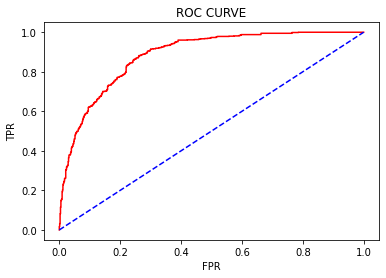

In [72]:
roc_curv(y_test,y_pred_prob)

## TRY OTHER MODELS

In [73]:
def model_results(model,x_train,y_train,x_test,y_test):
    print(str(model))

    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
   
    validation(y_test,y_pred)
    
    y_pred_prob = model.predict_proba(x_test)[:,1]
    
    roc_curv(y_test,y_pred_prob)

GaussianNB()
Confusion Matrix
 [[512 244]
 [ 96 659]]
Accuracy 0.7749834546657842
Precison 0.7297895902547066
Recall 0.8728476821192053
F1 Score 0.7949336550060313
Cohen kappa Score 0.550025050187964
Classification Report
               precision    recall  f1-score   support

           0       0.84      0.68      0.75       756
           1       0.73      0.87      0.79       755

    accuracy                           0.77      1511
   macro avg       0.79      0.78      0.77      1511
weighted avg       0.79      0.77      0.77      1511

AUC: 0.858481376362171


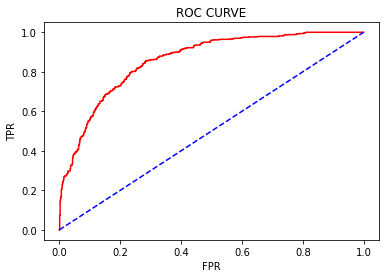

In [74]:
model_results(GaussianNB(),x_train,y_train,x_test,y_test)

DecisionTreeClassifier(max_depth=5)
Confusion Matrix
 [[599 157]
 [125 630]]
Accuracy 0.813368630046327
Precison 0.8005082592121983
Recall 0.8344370860927153
F1 Score 0.8171206225680934
Cohen kappa Score 0.6267475595484201
Classification Report
               precision    recall  f1-score   support

           0       0.83      0.79      0.81       756
           1       0.80      0.83      0.82       755

    accuracy                           0.81      1511
   macro avg       0.81      0.81      0.81      1511
weighted avg       0.81      0.81      0.81      1511

AUC: 0.8695180279617366


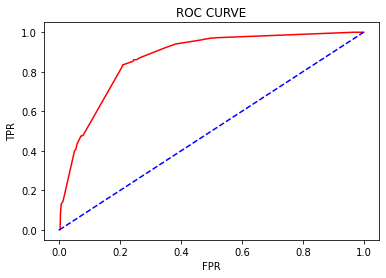

In [75]:
model_results(DecisionTreeClassifier(max_depth=5),x_train,y_train,x_test,y_test)

RandomForestClassifier(max_depth=5, n_estimators=500)
Confusion Matrix
 [[538 218]
 [ 89 666]]
Accuracy 0.7968232958305758
Precison 0.753393665158371
Recall 0.8821192052980132
F1 Score 0.8126906650396584
Cohen kappa Score 0.5936923277705224
Classification Report
               precision    recall  f1-score   support

           0       0.86      0.71      0.78       756
           1       0.75      0.88      0.81       755

    accuracy                           0.80      1511
   macro avg       0.81      0.80      0.80      1511
weighted avg       0.81      0.80      0.80      1511

AUC: 0.8869406776691545


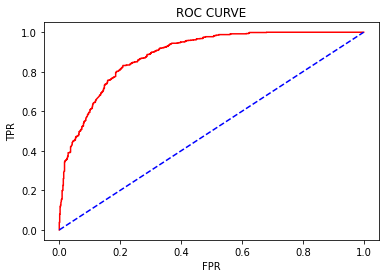

In [76]:
model_results(RandomForestClassifier(n_estimators=500,max_depth=5),x_train,y_train,x_test,y_test)

GradientBoostingClassifier(n_estimators=200)
Confusion Matrix
 [[615 141]
 [ 87 668]]
Accuracy 0.8491065519523494
Precison 0.8257107540173053
Recall 0.8847682119205298
F1 Score 0.8542199488491048
Cohen kappa Score 0.6982272466875844
Classification Report
               precision    recall  f1-score   support

           0       0.88      0.81      0.84       756
           1       0.83      0.88      0.85       755

    accuracy                           0.85      1511
   macro avg       0.85      0.85      0.85      1511
weighted avg       0.85      0.85      0.85      1511

AUC: 0.9205534531693471


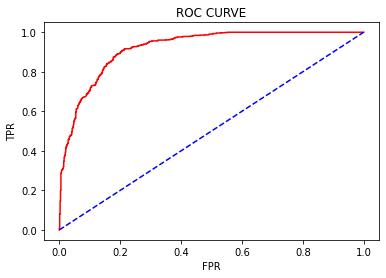

In [77]:
model_results(GradientBoostingClassifier(n_estimators=200),x_train,y_train,x_test,y_test)

The data was imbalanced so we used Random Over sampller to balance the data. We compared all the models and Gradient Boosting seems to be best model for the data with ~85% Accuracy and 84% f1 score for <=50K class and 85% f1 score for >50K class